In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Synthetic core and lithosphere with tapered ensembles as prior"
nb_name = "nb_case_lith_synthetic"

In [2]:
shc_g = 30
shc_grid = 30

lith = SDSS(comment, N_SH = shc_g, sim_type = "lith_ens", sat_height = 350)

lith.grid_glq(nmax = shc_grid, r_at = lith.a)

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = False)
lith.generate_map()

lith.condtab(normsize=10000, quantiles = 1000, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


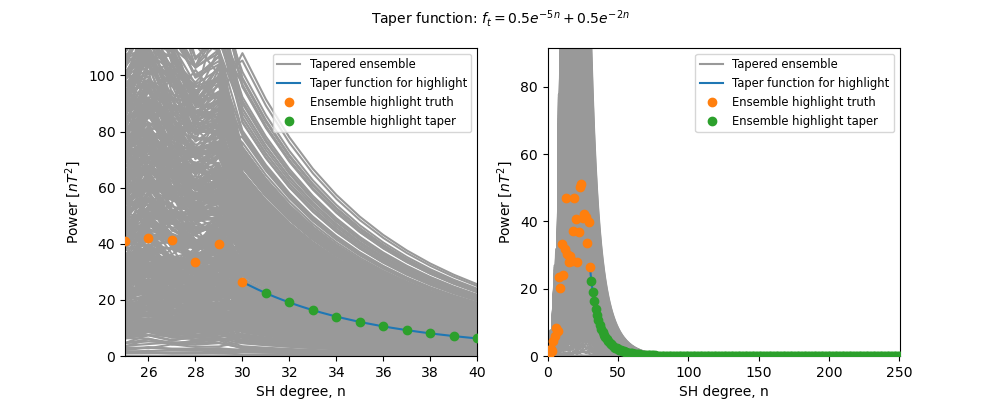

In [3]:
lith.cov_model_taper(r_at = lith.a, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
                     save_fig = False, save_string = "case_lith_synthetic", save_dpi = 300)

In [24]:
C_e_const = 0.01

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "surface", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

In [25]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "surface", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = s_source.a)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.a, grid_in, calc_sph_d = False)

s_source.generate_map()

In [26]:
lith.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = lith.C_ens_tap)

In [ ]:
N_sim = 4
lith.target_var = np.max(lith.C_ens_tap)

lith.run_sim(N_sim, lith.grid_N, lith.C_mm_all, lith.C_dd, lith.C_dm_all, lith.G,
        s_sat.data, lith.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

 |OOOOOOOOO-| 95.1%   realization nr. 0. Counter: 1798/1891, Running error magnitude: 1.0

In [8]:
lith.realization_to_sh_coeff(lith.r_cmb, set_nmax = shc_grid)

<IPython.core.display.Javascript object>


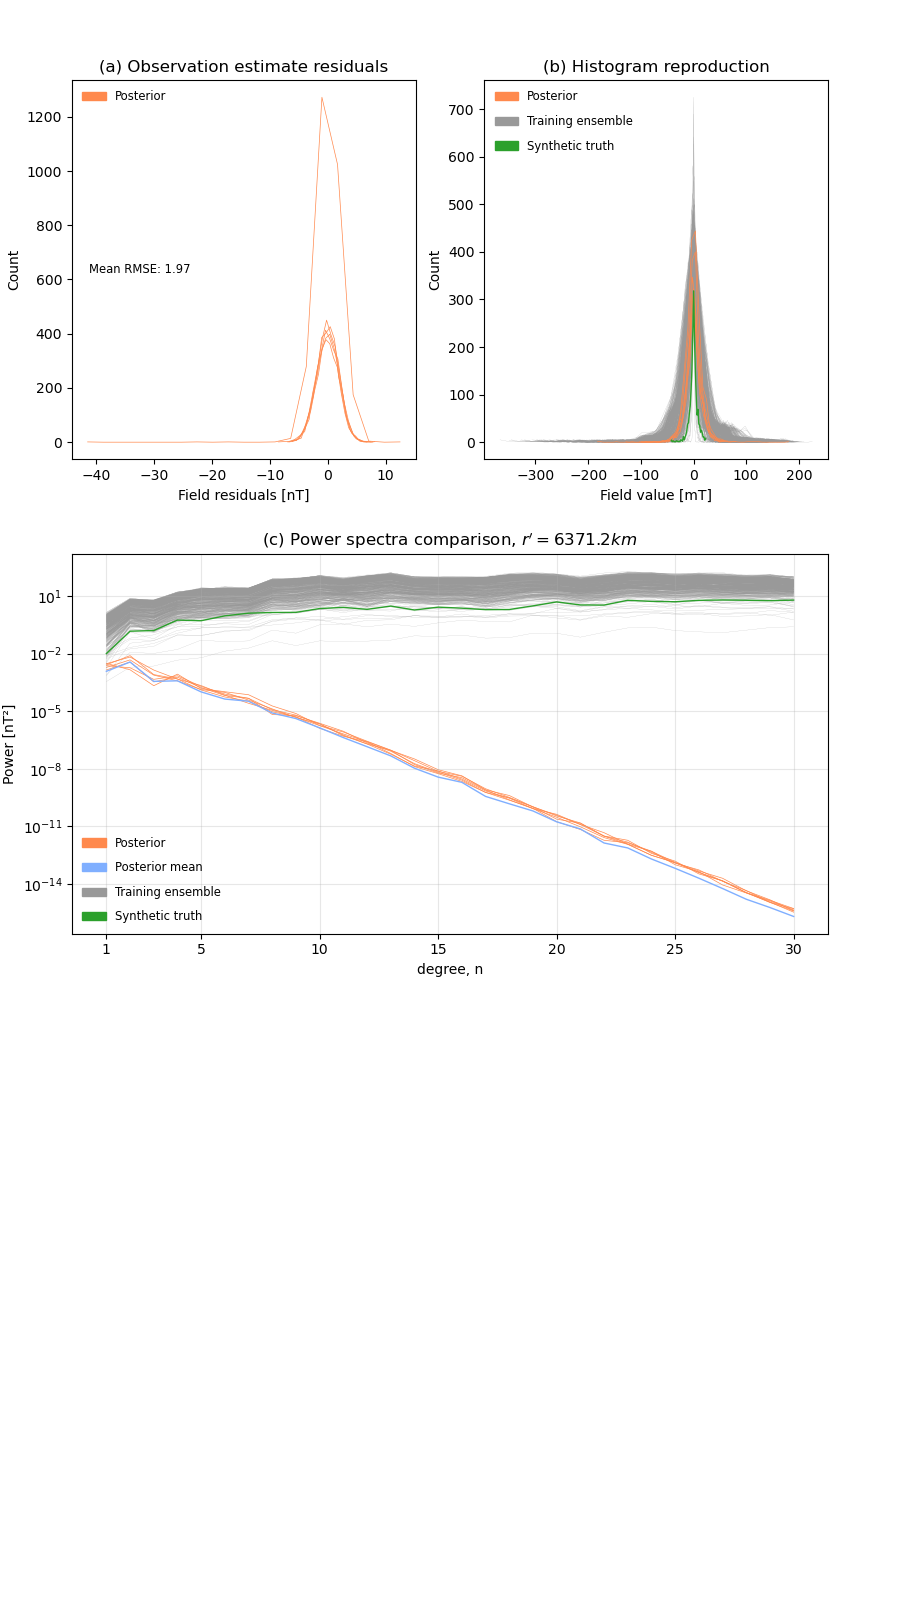

In [23]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

lith.grid_glq(nmax = shc_grid, r_at = lith.a)
mt_util.plot_sdssim_reproduce(lith, lith.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = lith.a, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = .5, label_fontsize = "small",
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = False, patch_legend = True, ens_prior = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_lith_synthetic", save_dpi = 300)

In [12]:
#core.pickle_save_self(nb_name)


Saving job

Job saved and finished


In [21]:
lith.grid_glq(nmax = 256, r_at = lith.a)

set_nmax = shc_grid

lith.ensemble_B(lith.g_spec, nmax = set_nmax, r_at = lith.a, grid_type = "glq")
zs_eqa = lith.B_ensemble[:,0,:].copy()

lith.ensemble_B(lith.g_spec_mean, nmax = set_nmax, r_at = lith.a, grid_type = "glq")
zs_mean_eqa = lith.B_ensemble[:,0].copy()

lith.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = lith.a, grid_type = "glq")
prior_eqa = lith.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


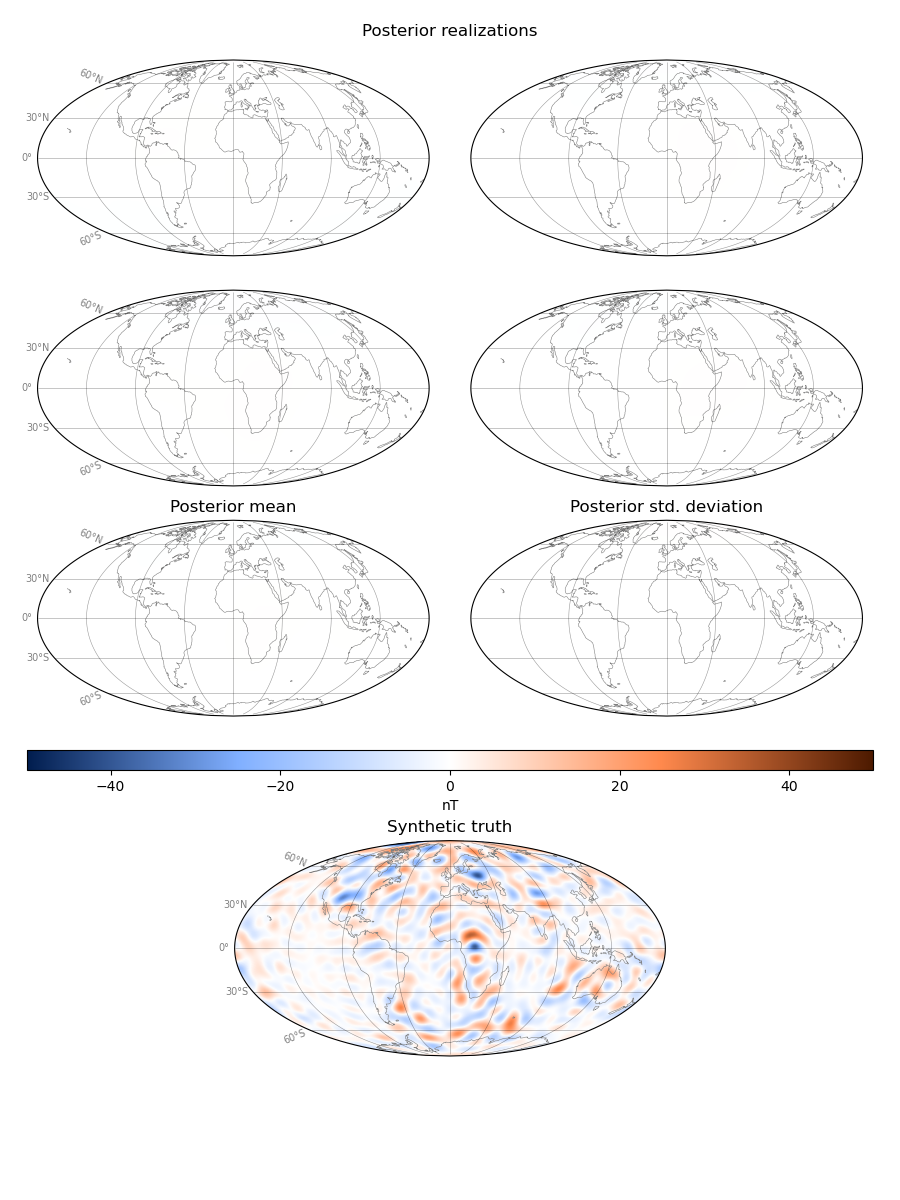

In [22]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(lith.grid_phi, 90-lith.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = False,
                        cbar_h = 0.1, cbar_text = "nT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_lith_synthetic", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
